<center> 
    <b>
    <font size = 8, color = '#04ef62'>
        Credit Card Fraud Detection
    </b>
</center>

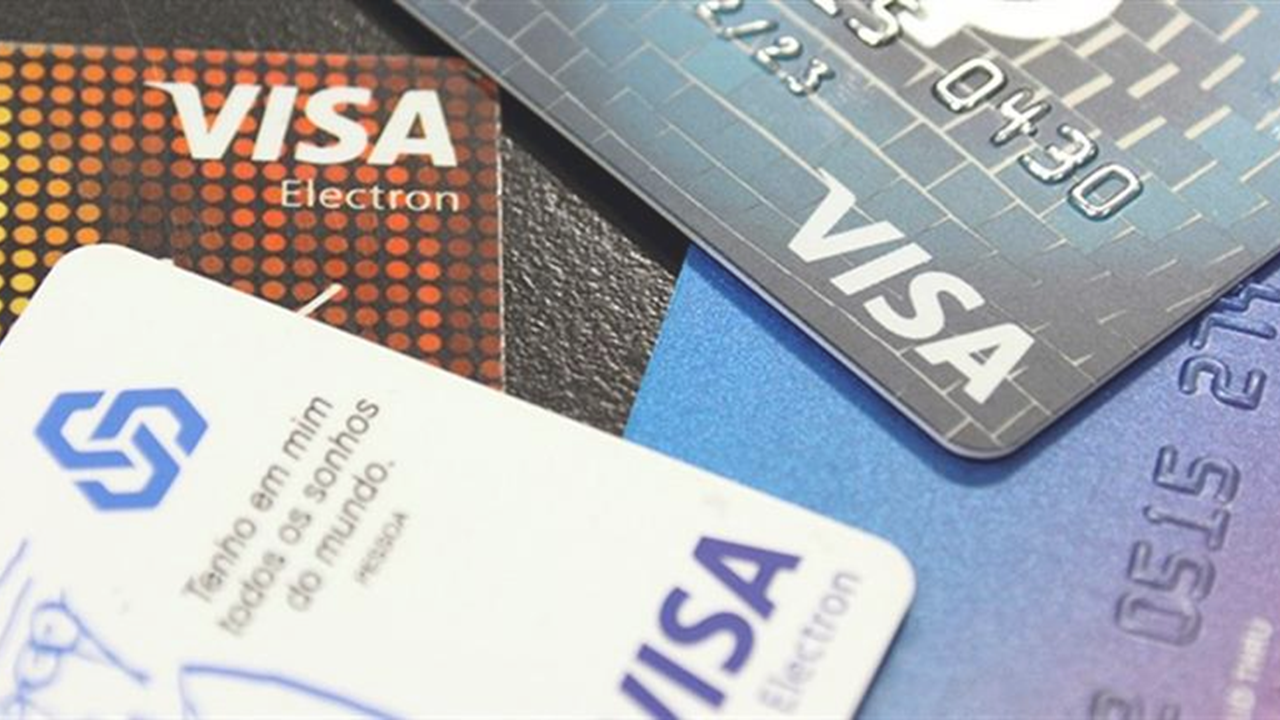

In [1]:
from IPython.display import display, Image
display(Image('CreditCardFraudDetectionCover.png'))

## Summary

This project focuses on the supervised phase of <a href = 'https://scikit-learn.org/stable/modules/outlier_detection.html#id1' target = '_blank'>Anomaly Detection (Outlier Detection)</a> for identifying credit card fraud cases. Three candidate estimators were evaluated: DBSCAN, Isolation Forest, and Local Outlier Factor. The dataset, generated using Sparkov Data Generation, simulates a credit card transaction database spanning from January 1, 2019, to December 31, 2020. It encompasses transactions involving 1,000 customers and a network of 800 merchants, capturing both legitimate and fraudulent activities.

## Dependencies

In [45]:
# Suppresing warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Data Manipulation
import pandas as pd
import numpy as np
import time

# Plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, RocCurveDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from eval_models import plot_eps_values

## Data Preparation

In [3]:
# Reading the datasets as Pandas DataFrames

df_train = pd.read_csv('fraudTrain.csv').iloc[:, 1:]
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
# Main information about the dataset

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [5]:
# Conversion of transaction date time column to unix and object attributes to category for a more efficient memory usage

df_train['trans_date_trans_time'] = df_train.trans_date_trans_time.map(lambda cell: int(time.mktime(time.strptime(cell, '%Y-%m-%d %H:%M:%S'))))

for col in df_train.columns:
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].astype('category')
    else:
        pass
        
df_train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   trans_date_trans_time  1296675 non-null  int64   
 1   cc_num                 1296675 non-null  int64   
 2   merchant               1296675 non-null  category
 3   category               1296675 non-null  category
 4   amt                    1296675 non-null  float64 
 5   first                  1296675 non-null  category
 6   last                   1296675 non-null  category
 7   gender                 1296675 non-null  category
 8   street                 1296675 non-null  category
 9   city                   1296675 non-null  category
 10  state                  1296675 non-null  category
 11  zip                    1296675 non-null  int64   
 12  lat                    1296675 non-null  float64 
 13  long                   1296675 non-null  float64 
 14  ci

In [6]:
# Statistical summary

df_train.describe().round(2)

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1296675.00,1296675.00,1296675.00,1296675.00,1296675.00,1.296675e+06,1296675.00,1296675.00,1296675.00
mean,1.570103e+09,4.171920e+17,70.35,48800.67,38.54,-90.23,88824.44,1.349244e+09,38.54,-90.23,0.01
std,1.285545e+07,1.308806e+18,160.32,26893.22,5.08,13.76,301956.36,1.284128e+07,5.11,13.77,0.08
min,1.546297e+09,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.559586e+09,1.800429e+14,9.65,26237.00,34.62,-96.80,743.00,1.338751e+09,34.73,-96.90,0.00
50%,1.570085e+09,3.521417e+15,47.52,48174.00,39.35,-87.48,2456.00,1.349250e+09,39.37,-87.44,0.00
75%,1.580220e+09,4.642255e+15,83.14,72042.00,41.94,-80.16,20328.00,1.359385e+09,41.96,-80.24,0.00
max,1.592738e+09,4.992346e+18,28948.90,99783.00,66.69,-67.95,2906700.00,1.371817e+09,67.51,-66.95,1.00


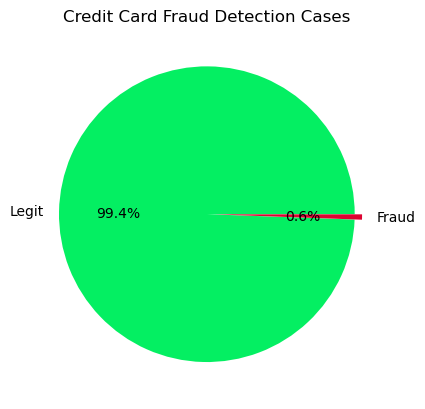

In [7]:
# Counting fraud cases 

palette_ = ['#04ef62', '#dc0432', '#4287f5']
df_train.is_fraud.value_counts().plot.pie(autopct = '%.1f%%', 
                                        labels = ['Legit', 'Fraud'], colors = palette_, explode = (0, .05))
plt.ylabel('')
plt.title('Credit Card Fraud Detection Cases', fontsize = 12)
plt.show()

## Anomaly Detection

In [8]:
# Splitting data into independent and dependent sets

data, y_true = df_train.iloc[:, :-1], df_train.is_fraud.values

- DBSCAN

In [9]:
# Since not all columns might be relevant for our analysis while others may carry redundant information, we'll focus on removing some of them, 
# especially those with categorical attributes that may lead to high cardinality on techniques based on metric values

dbscan_data = data[data.dtypes[data.dtypes != 'category'].index]
dbscan_data.head()

,trans_date_trans_time,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long
0,1546297218,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315
1,1546297244,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462
2,1546297251,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481
3,1546297276,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071
4,1546297386,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459


In [10]:
# Scaling the data and listing techniques to be used in outlier detection

scaled_data = RobustScaler().fit_transform(dbscan_data)
approach = ['DBSCAN', 'Isolation Forest', 'Local Outlier Factor']

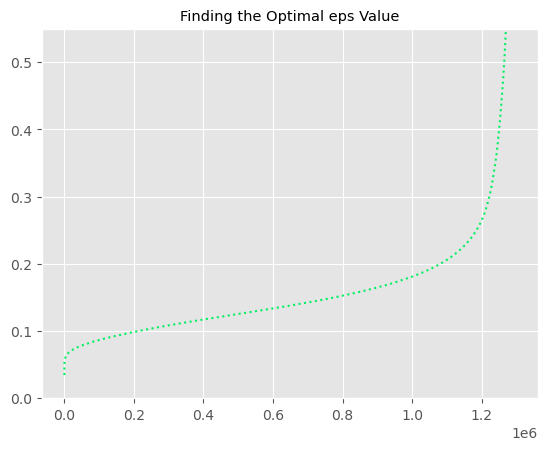

In [11]:
# Analysing the optimal maximum distance between two samples

plot_eps_values(scaled_data, ylim = .55, color_ = palette_[0])

In [12]:
# DBSCAN settings

min_samples = scaled_data.shape[1] * 2
dbscan = DBSCAN(eps = .28, min_samples = min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

y_pred_dbscan = np.where(dbscan_labels == -1, 1, 0)
y_pred_dbscan.mean() # Anomaly fraction from predictions

0.0728887346482349

- Local Outlier Factor

In [13]:
# Customed scorer

def scorer(estimator, data):
    if estimator.__class__.__name__ == 'LocalOutlierFactor':        
        scores = estimator.negative_outlier_factor_
    else:
        scores = estimator.decision_function(data)
    return scores.mean()

scoring_ = make_scorer(scorer)

In [14]:
# Setting up the LOF estimator and grid search cross-validation

lof = LocalOutlierFactor()
param_grid_lof = {
    'n_neighbors': [n for n in range(20, 100, 20)]
}
grid_search_lof = GridSearchCV(
    estimator = lof,
    param_grid = param_grid_lof,
    scoring = scoring_
)
grid_search_lof.fit(scaled_data)
print(grid_search_lof.best_params_)

{'n_neighbors': 20}


In [15]:
# Results from LOF best estimator (since LOF is a metric-based technique, it will be implemented the same portion of data used for DBSCAN)

lof_labels = grid_search_lof.best_estimator_.fit_predict(scaled_data)
y_pred_lof = np.where(lof_labels == -1, 1, 0)
y_pred_lof.mean() 

0.0016673414695278308

- Isolation Forest 

In [16]:
# Estimators for Isolation Forest

isolation_forest = IsolationForest(random_state = 7)
param_grid_iforest = {
    'n_estimators': [100, 200, 300]
}
grid_search_iforest = GridSearchCV(
    estimator = isolation_forest,
    param_grid = param_grid_iforest,
    scoring = scoring_
)

In [17]:
# Grid search setup and data fitting (since Isolation Forest is a tree-based algorithm, the categorical attributes will be considered here  and
# labelled using ordinal encoder so we can avoid high cardinality)

transformer = ColumnTransformer(transformers = [
    ('numeric_columns', RobustScaler(), list(dbscan_data.columns))], 
                                remainder = OrdinalEncoder())
transformed_data = transformer.fit_transform(data)
grid_search_iforest.fit(transformed_data)
print(grid_search_iforest.best_params_)

{'n_estimators': 100}


In [18]:
# Getting results from the best estimator

iforest_labels = grid_search_iforest.best_estimator_.fit_predict(transformed_data)
y_pred_iforest = np.where(iforest_labels == -1, 1, 0)
y_pred_iforest.mean() 

0.27556249638498465

## Performance Assessment

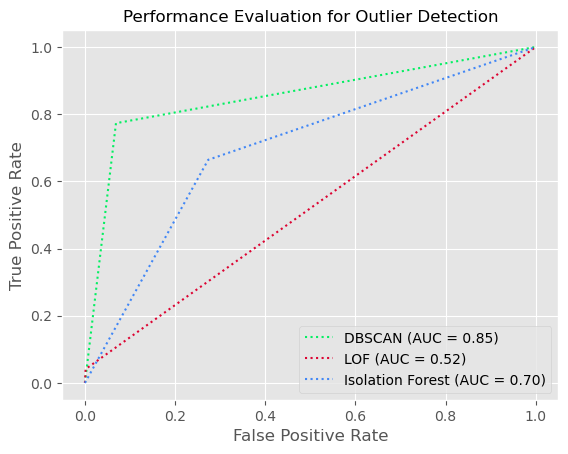

In [19]:
# Performance evaluation across the three estimators

pred_dict = {'DBSCAN': y_pred_dbscan, 'LOF': y_pred_lof, 'Isolation Forest': y_pred_iforest}
for i, (technique, pred_data) in enumerate(pred_dict.items()):
    ax = plt.subplot()
    RocCurveDisplay.from_predictions(y_true, pred_data, ax = ax, name = technique, 
                                     linestyle = ':', color = palette_[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Performance Evaluation for Outlier Detection', fontsize = 12)
plt.show()

<strong> Source </strong>
<br>
Credit Card Transactions Fraud Detection Dataset
<em><a href = 'https://ieeexplore.ieee.org/document/4781136' target = '_blank'>
Simulated Credit Card Transactions generated using Sparkov.
</a></em>
<br><br>

<strong> References </strong>
- Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua.<em><a href = 'https://ieeexplore.ieee.org/document/4781136' target = '_blank'>
“Isolation forest.” Data Mining, 2008. ICDM’08.
</a></em> Eighth IEEE International Conference on Data Mining.
- Breunig, Kriegel, Ng, and Sander (2000) <em><a href = 'https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf' target = '_blank'>
LOF: identifying density-based local outliers.</a></em> Proc. ACM SIGMOD.
<br><br>

<strong> Acknowledgement </strong>
<br>
Brandon Harris, creator of
<em><a href = 'https://github.com/namebrandon/Sparkov_Data_Generation' target = '_blank'>
Sparkov Data Generation.</a></em>
<br><br>

<strong> Cover </strong>
<br>
From <b> Expansão, </b> in <em><a href = 'https://expansao.co.ao/economia/interior/gastos-dos-angolanos-em-cartoes-pre-pagos-triplicaram-111108.html' target = '_blank'> 
Gastos dos angolanos em cartões pré-pagos triplicaram.</a></em>
<br><br><br>

<em>Last accessed on December, 12 2024.</em>